In [18]:
import pandas as pd
from typing import Dict, Callable, List
#!pip install ray
import ray
ray.init(num_cpus=4)

2024-04-03 17:15:59,574	INFO worker.py:1752 -- Started a local Ray instance.


Python version:,3.9.16
Ray version:,2.10.0


(raylet) [2024-04-03 17:16:08,516 E 25208 981663] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-03_17-15-56_569217_25133 is over 95% full, available space: 12012269568; capacity: 250685575168. Object creation will fail if spilling is required.
(raylet) [2024-04-03 17:16:18,589 E 25208 981663] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-03_17-15-56_569217_25133 is over 95% full, available space: 12013797376; capacity: 250685575168. Object creation will fail if spilling is required.
(raylet) [2024-04-03 17:16:28,664 E 25208 981663] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-03_17-15-56_569217_25133 is over 95% full, available space: 12013604864; capacity: 250685575168. Object creation will fail if spilling is required.
(raylet) [2024-04-03 17:16:38,748 E 25208 981663] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-03_17-15-56_569217_25133 is over 95% full, available space: 12013477888; capacity: 250685575168. Object crea

# figuring out groupby

In [157]:
# Defined based on the logic you are doing
def grouped_mean_chunk(df: pd.DataFrame, groupCols: List, selectCol: str, **kwargs) -> pd.DataFrame:
    df['countries_en_c'] = df.countries_en.str.lower()
    df.countries_en_c = df.countries_en_c.str.strip()
    df.countries_en_c = df.countries_en_c.str.replace(r"\s+", " ")
    df.countries_en_c = df.countries_en_c.str.replace(r",\s+", ",")
    df.countries_en_c = df.countries_en_c.str.replace(r"[\*|\?|\.]", "")
    df = df.assign(countries=df['countries_en_c'].str.split(',')).explode('countries').reset_index(drop=True)

    #could fill w median instead
    #df[selectCol] = df[selectCol].fillna(0)
    df = df.dropna(subset=[selectCol])

    return df.groupby(groupCols)[selectCol].agg(['count', 'sum'])

# Defined based on the logic you are doing
def grouped_mean_agg(df: pd.DataFrame, rename: str, groupCols: List, **kwargs) -> pd.DataFrame:
    df = df.reset_index()
    agg_df = df.groupby(groupCols).agg(total_sum=('sum', 'sum'), total_count=('count', 'sum'))
    agg_df[rename] = agg_df.apply(lambda row: row['total_sum'] / row['total_count'], axis=1)
    
    return agg_df[rename].reset_index()

# Will not be changed
@ray.remote
def process_chunk(chunk: pd.DataFrame, dfMethod: Callable, **kwargs) -> pd.DataFrame:
    """
    Calculate the mean of specified columns, grouped by a specified category, for a given DataFrame chunk.

    Args:
    - chunk (pd.DataFrame): A chunk of the DataFrame.
    - dfMethod (Callable): A function that takes in a dataframe as an input and returns a dataframe
    - **kwargs: Additional keyword arguments to pass to dfMethod.

    Returns:
    - pd.DataFrame
    """
    return dfMethod(chunk, **kwargs)

# Will not be changed
def process_file(file_path: str, dfMethod: Callable, aggMethod: Callable, separator: str = '\t', save: bool = False, **kwargs) -> None:
    """
    Process a large CSV file to compute grouped means for specified columns and save the results.

    Args:
    - file_path (str): The path to the CSV file.
    - dfMethod (Callable): A function that takes in a dataframe (chunk) as an input and returns a dataframe
    - aggMethod (Callable): A function that aggregates the concatenated results from all chunks
    - separator (str): delimiter for the input file
    - **kwargs: Additional keyword arguments to pass to both dfMethod and aggMethod.
    """
    chunk_size = 1000  # Define chunk size based on system's memory.

    results = []
    for chunk in pd.read_csv(file_path, chunksize=chunk_size, sep=separator, low_memory=False):
        result = process_chunk.remote(chunk, dfMethod, **kwargs)
        results.append(result)

    # Retrieve and combine results from all chunks.
    combined_results = pd.concat(ray.get(results))

    # Uncomment for debugging purposes. 
    # combined_results.to_csv("data/grouped_means_combined.csv", index=True)

    # Final aggregation to ensure accurate mean calculation across all chunks.
    final_result = aggMethod(combined_results, **kwargs)

    #if save:
       # final_result.to_csv("data/grouped_means_results.csv", index=False)
        
    return final_result



In [158]:
groupCols = ['countries']
selectCol = 'ecoscore_score'
rename = 'mean_ecoscore_score'

final_df = process_file(
    file_path='small_subset.csv',
    dfMethod=grouped_mean_chunk,
    aggMethod=grouped_mean_agg,
    separator=',',
    save=False,
    groupCols=groupCols,
    selectCol=selectCol,
    rename=rename
)

In [159]:
import pycountry
import plotly.express as px

iso_mapping = {}
for country in final_df['countries']:
    try:
        country_data = pycountry.countries.search_fuzzy(country)[0]
        iso_mapping[country] = country_data.alpha_3
    except LookupError:
        print(f"No ISO code found for {country}. Dropping from DataFrame.")
        final_df = final_df[final_df['countries'] != country]

# Add ISO codes to the DataFrame
final_df['ISO_Code'] = final_df['countries'].map(iso_mapping)



No ISO code found for european union. Dropping from DataFrame.
No ISO code found for fr:schweiz. Dropping from DataFrame.
No ISO code found for galmudug. Dropping from DataFrame.
SubdivisionHierarchy(code='FR-971', country_code='FR', name='Guadeloupe', parent='GP', parent_code='FR-GP', type='Overseas department')
SubdivisionHierarchy(code='FR-GP', country_code='FR', name='Guadeloupe', parent_code=None, type='Overseas region')
SubdivisionHierarchy(code='BE-WLX', country_code='BE', name='Luxembourg', parent='WAL', parent_code='BE-WAL', type='Province')
SubdivisionHierarchy(code='LU-LU', country_code='LU', name='Luxembourg', parent_code=None, type='Canton')
SubdivisionHierarchy(code='GN-ML', country_code='GN', name='Mali', parent='L', parent_code='GN-L', type='Prefecture')
SubdivisionHierarchy(code='FR-972', country_code='FR', name='Martinique', parent='MQ', parent_code='FR-MQ', type='Overseas department')
SubdivisionHierarchy(code='FR-MQ', country_code='FR', name='Martinique', parent_cod

(raylet) [2024-04-03 19:01:38,329 E 25208 981663] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-03_17-15-56_569217_25133 is over 95% full, available space: 11925467136; capacity: 250685575168. Object creation will fail if spilling is required.


In [160]:
final_df

,countries,mean_ecoscore_score,ISO_Code
0,afghanistan,56.200000,AFG
1,algeria,42.500000,DZA
2,andorra,60.000000,AND
3,australia,41.666667,AUS
4,austria,27.200000,AUT
...,...,...,...
60,switzerland,57.198758,CHE
61,togo,104.000000,TGO
62,united arab emirates,16.000000,ARE
63,united kingdom,54.314286,GBR


(raylet) [2024-04-03 19:01:48,392 E 25208 981663] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-03_17-15-56_569217_25133 is over 95% full, available space: 11924164608; capacity: 250685575168. Object creation will fail if spilling is required.
(raylet) [2024-04-03 19:01:58,467 E 25208 981663] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-03_17-15-56_569217_25133 is over 95% full, available space: 11923689472; capacity: 250685575168. Object creation will fail if spilling is required.
(raylet) [2024-04-03 19:02:08,545 E 25208 981663] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-03_17-15-56_569217_25133 is over 95% full, available space: 11923226624; capacity: 250685575168. Object creation will fail if spilling is required.
(raylet) [2024-04-03 19:02:18,608 E 25208 981663] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-03_17-15-56_569217_25133 is over 95% full, available space: 11922726912; capacity: 250685575168. Object crea

In [161]:
# Plot the scores on a geographical map
fig = px.choropleth(final_df,
                    locations="ISO_Code",
                    color="mean_ecoscore_score",
                    hover_name="countries",
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title="Scores by Country")
fig.show()

# nutriscore

In [167]:
groupCols = ['countries']
selectCol = 'nutriscore_score'
rename = 'mean_nutriscore_score'

final_df = process_file(
    file_path='small_subset.csv',
    dfMethod=grouped_mean_chunk,
    aggMethod=grouped_mean_agg,
    separator=',',
    save=False,
    groupCols=groupCols,
    selectCol=selectCol,
    rename=rename
)

In [169]:

iso_mapping = {}
for country in final_df['countries']:
    try:
        country_data = pycountry.countries.search_fuzzy(country)[0]
        iso_mapping[country] = country_data.alpha_3
    except LookupError:
        print(f"No ISO code found for {country}. Dropping from DataFrame.")
        final_df = final_df[final_df['countries'] != country]

# Add ISO codes to the DataFrame
final_df['ISO_Code'] = final_df['countries'].map(iso_mapping)



No ISO code found for fr:francia. Dropping from DataFrame.
No ISO code found for fr:schweiz. Dropping from DataFrame.
No ISO code found for galmudug. Dropping from DataFrame.
SubdivisionHierarchy(code='FR-971', country_code='FR', name='Guadeloupe', parent='GP', parent_code='FR-GP', type='Overseas department')
SubdivisionHierarchy(code='FR-GP', country_code='FR', name='Guadeloupe', parent_code=None, type='Overseas region')
SubdivisionHierarchy(code='BE-WLX', country_code='BE', name='Luxembourg', parent='WAL', parent_code='BE-WAL', type='Province')
SubdivisionHierarchy(code='LU-LU', country_code='LU', name='Luxembourg', parent_code=None, type='Canton')
SubdivisionHierarchy(code='FR-972', country_code='FR', name='Martinique', parent='MQ', parent_code='FR-MQ', type='Overseas department')
SubdivisionHierarchy(code='FR-MQ', country_code='FR', name='Martinique', parent_code=None, type='Overseas region')
SubdivisionHierarchy(code='MX-MEX', country_code='MX', name='México', parent_code=None, ty

In [170]:
len(final_df)

49

(raylet) [2024-04-03 19:14:32,025 E 25208 981663] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-03_17-15-56_569217_25133 is over 95% full, available space: 11938095104; capacity: 250685575168. Object creation will fail if spilling is required.


In [172]:
fig = px.choropleth(final_df,
                    locations="ISO_Code",
                    color="mean_nutriscore_score",
                    hover_name="countries",
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title="Scores by Country")
fig.show()

(raylet) [2024-04-03 19:14:42,121 E 25208 981663] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-03_17-15-56_569217_25133 is over 95% full, available space: 11938103296; capacity: 250685575168. Object creation will fail if spilling is required.
(raylet) [2024-04-03 19:14:52,198 E 25208 981663] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-03_17-15-56_569217_25133 is over 95% full, available space: 11938099200; capacity: 250685575168. Object creation will fail if spilling is required.
(raylet) [2024-04-03 19:15:02,263 E 25208 981663] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-03_17-15-56_569217_25133 is over 95% full, available space: 11938562048; capacity: 250685575168. Object creation will fail if spilling is required.
(raylet) [2024-04-03 19:15:12,330 E 25208 981663] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-03_17-15-56_569217_25133 is over 95% full, available space: 11938488320; capacity: 250685575168. Object crea

# Spider

In [98]:
def process_data_chunk(chunk, column, ascend ):
    # Sort the chunk and take top 3 values
    chunk = chunk.dropna(subset=["sodium_100g", 'fat_100g','saturated-fat_100g','sugars_100g','carbohydrates_100g','proteins_100g', 'ecoscore_score',	'nutriscore_score']).reset_index()
    sorted_chunk = chunk.sort_values(by = column ,ascending= ascend).head(3)
    return sorted_chunk


# Will not be changed
@ray.remote
def process_chunk(chunk: pd.DataFrame, dfMethod: Callable,column: Callable, ascend:Callable, **kwargs) -> pd.DataFrame:
    """
    Calculate the mean of specified columns, grouped by a specified category, for a given DataFrame chunk.

    Args:
    - chunk (pd.DataFrame): A chunk of the DataFrame.
    - dfMethod (Callable): A function that takes in a dataframe as an input and returns a dataframe
    - **kwargs: Additional keyword arguments to pass to dfMethod.

    Returns:
    - pd.DataFrame
    """
    return dfMethod(chunk,column,ascend, **kwargs)

# Will not be changed
def process_file(file_path: str, dfMethod: Callable, column :Callable, ascend: Callable, separator: str = '\t', **kwargs) -> None:
    """
    Process a large CSV file to compute grouped means for specified columns and save the results.

    Args:
    - file_path (str): The path to the CSV file.
    - dfMethod (Callable): A function that takes in a dataframe (chunk) as an input and returns a dataframe
    - aggMethod (Callable): A function that aggregates the concatenated results from all chunks
    - separator (str): delimiter for the input file
    - **kwargs: Additional keyword arguments to pass to both dfMethod and aggMethod.
    """
    chunk_size = 1000  # Define chunk size based on system's memory.

    results = []
    for chunk in pd.read_csv(file_path, chunksize=chunk_size, sep=separator, low_memory=False):
        result = process_chunk.remote(chunk, dfMethod, column,ascend, **kwargs)
        results.append(result)

    # Retrieve and combine results from all chunks.
    combined_results = pd.concat(ray.get(results))

    combined_results= combined_results.sort_values(by = column ,ascending= ascend).head(10)


   # if save:
    #    final_result.to_csv("data/grouped_means_results.csv", index=False)
        
    return combined_results

# Non-ecofriendly foods

In [99]:



df = process_file(
    file_path='small.csv',
    dfMethod=process_data_chunk,
    column = 'ecoscore_score',
    ascend = True,
   
)

In [101]:
df= df[['code',
 'product_name',
 'countries_en',
 'countries_en',
 'ecoscore_score',
 'nutriscore_score',
 'sodium_100g',
 'fat_100g',
 'saturated-fat_100g',
 'sugars_100g',
 'carbohydrates_100g',
 'proteins_100g']]

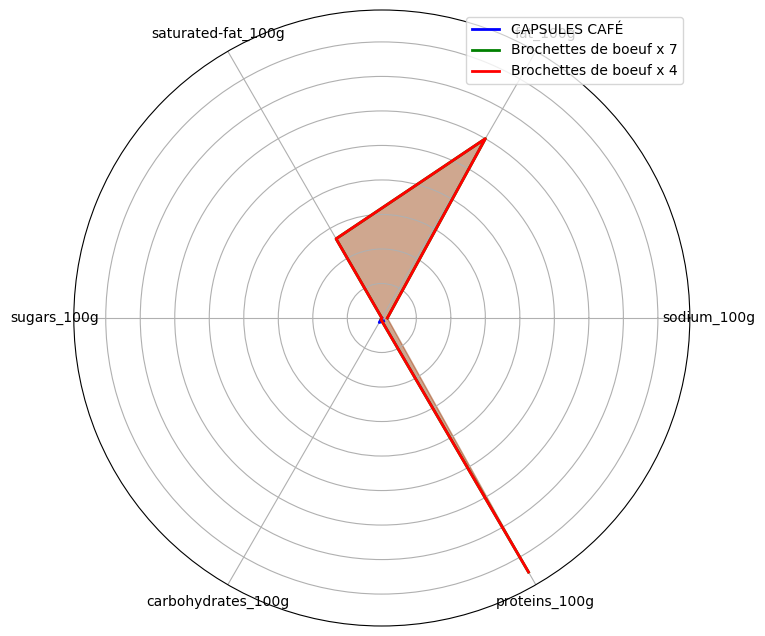

(raylet) [2024-04-03 17:42:10,530 E 25208 981663] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-03_17-15-56_569217_25133 is over 95% full, available space: 11946360832; capacity: 250685575168. Object creation will fail if spilling is required.
(raylet) [2024-04-03 17:42:20,610 E 25208 981663] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-03_17-15-56_569217_25133 is over 95% full, available space: 11945136128; capacity: 250685575168. Object creation will fail if spilling is required.


In [102]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have selected_rows, columns_to_graph, and num_features defined

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

colors = ['blue', 'green', 'red']  # Choose your colors for each graph
selected_rows = df.head(3)
columns_to_graph = ["sodium_100g", 'fat_100g','saturated-fat_100g','sugars_100g','carbohydrates_100g','proteins_100g']
num_features = len(columns_to_graph)


for index, row in selected_rows.reset_index().iterrows():

    product_name = row['product_name']
    values = row[columns_to_graph].values
    angles = np.linspace(0, 2 * np.pi, num_features, endpoint=False).tolist()
    ax.fill(angles, values, color=colors[index], alpha=0.25)
    ax.plot(angles, values, color=colors[index], linewidth=2, label=product_name)

ax.set_yticklabels([])
ax.set_xticks(angles)
ax.set_xticklabels(columns_to_graph)
ax.legend()  # Add legend to distinguish different products

plt.show()

# nutriscore: bad for you foods

In [104]:



df = process_file(
    file_path='small.csv',
    dfMethod=process_data_chunk,
    column = 'nutriscore_score',
    ascend = False,
   
)

In [105]:
df = df[['code',
 'product_name',
 'countries_en',
 'countries_en',
 'ecoscore_score',
 'nutriscore_score',
 'sodium_100g',
 'fat_100g',
 'saturated-fat_100g',
 'sugars_100g',
 'carbohydrates_100g',
 'proteins_100g']]

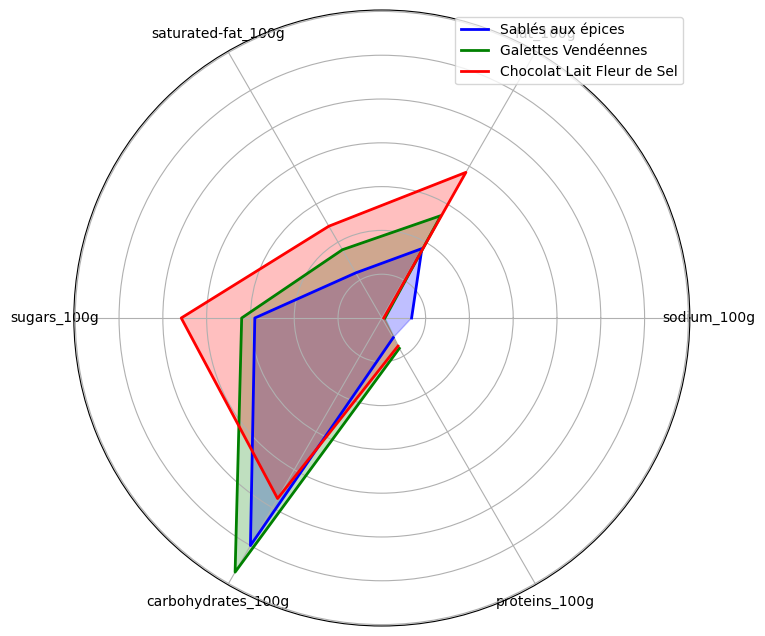

(raylet) [2024-04-03 17:42:50,827 E 25208 981663] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-03_17-15-56_569217_25133 is over 95% full, available space: 11945107456; capacity: 250685575168. Object creation will fail if spilling is required.
(raylet) [2024-04-03 17:43:00,895 E 25208 981663] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-03_17-15-56_569217_25133 is over 95% full, available space: 11945095168; capacity: 250685575168. Object creation will fail if spilling is required.
(raylet) [2024-04-03 17:43:10,953 E 25208 981663] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-03_17-15-56_569217_25133 is over 95% full, available space: 11945123840; capacity: 250685575168. Object creation will fail if spilling is required.
(raylet) [2024-04-03 17:43:21,018 E 25208 981663] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-03_17-15-56_569217_25133 is over 95% full, available space: 11945078784; capacity: 250685575168. Object crea

In [106]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have selected_rows, columns_to_graph, and num_features defined

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

colors = ['blue', 'green', 'red']  # Choose your colors for each graph
selected_rows = df.head(3)
columns_to_graph = ["sodium_100g", 'fat_100g','saturated-fat_100g','sugars_100g','carbohydrates_100g','proteins_100g']
num_features = len(columns_to_graph)


for index, row in selected_rows.reset_index().iterrows():

    product_name = row['product_name']
    values = row[columns_to_graph].values
    angles = np.linspace(0, 2 * np.pi, num_features, endpoint=False).tolist()
    ax.fill(angles, values, color=colors[index], alpha=0.25)
    ax.plot(angles, values, color=colors[index], linewidth=2, label=product_name)

ax.set_yticklabels([])
ax.set_xticks(angles)
ax.set_xticklabels(columns_to_graph)
ax.legend()  # Add legend to distinguish different products

plt.show()
